# Parseur à l'aide d'automates en STI

Ce document explique comment synthétiser un circuit minimal (au sens des automates finis déterministes, pas nécessairement au sens du nombre de transistors) détectant un motif binaire à l'aide d'une machine de Moore (donc théorie des automates en informatique). J'ai utilisé des bibliothèques Python adaptées (*automata*: https://github.com/caleb531/automata/ et Sympy) et déjà existantes pour simplifier la tâche. L'output produit est directement utilisable pour créer le circuit sur LTSpice.

In [20]:
from automata.fa.dfa import DFA
from automata.fa.nfa import NFA

from visual_automata.fa.dfa import VisualDFA
from visual_automata.fa.nfa import VisualNFA

import numpy as np
import sympy
import itertools

On commence par créer quelques automates pour vérifier que tout fonctionne

In [21]:
nfa = VisualNFA(
    states={"q0", "q1", "q2", "q3", "q4"},
    input_symbols={"0", "1"},
    transitions={
        "q0": {"0": {"q3"}, "1": {"q1", "q2"}},
        "q1": {"0": {"q3"}, "1": {"q1"}},
        "q2": {"0": {"q3"}, "1": {"q2", "q3"}},
        "q3": {"0": {"q4"}, "1": {"q1"}},
        "q4": {"0": {"q4"}, "1": {"q1"}},
    },
    initial_state="q0",
    final_states={"q2", "q4"},
)

dfa = VisualDFA(
    states={"q0", "q1", "q2", "q3", "q4"},
    input_symbols={"0", "1"},
    transitions={
        "q0": {"0": "q3", "1": "q1"},
        "q1": {"0": "q3", "1": "q2"},
        "q2": {"0": "q3", "1": "q2"},
        "q3": {"0": "q4", "1": "q1"},
        "q4": {"0": "q4", "1": "q1"},
    },
    initial_state="q0",
    final_states={"q2", "q4"},
)

# Synthèse d'automate de recherche de motif avec des portes OU et ET
## Construction naïve avec les méthodes de déterminisation de la classe `automata.fa`

In [219]:
## On commence par synthétiser les variables pour un AFD naïf qui cherche notre motif binaire
alphabet = {"0","1"}
motBinaire = "011"
motif = list(motBinaire)
etats = set([f"q{i}" for i in range(len(motif)+1)])
ef = f"q{len(motif)}"
trans = [{motif[i]:set([f"q{i+1}"])} for i in range(len(motif))]
delta = {f"q{i}":x for i,x in enumerate(trans)} # dict(enumerate(trans)) donnerait des entiers
# on ajoute les deux transitions absorbantes dans le dernier état:
delta[ef] = {e: {ef} for e in alphabet} # pour détecter une séquence    CONTENANT     le motif i.e. reconnaissant Σ*uΣ*
delta[ef] = {}                          # pour détecter une séquence SE TERMINANT par le motif i.e. reconnaissant Σ*u
# on ajoute les transitions absorbantes pour le premier état:
for a in alphabet:
    if a == motBinaire[0]:
        delta["q0"][a].add("q0")
    else:
        delta["q0"][a] = {"q0"}
        
## On crée ensuite l'automate à proprement parler dans la bibliothèque automata
## qu'on déterminise grâce à l'automate des parties puis minimise avec l'algorithme de Moore
nfa = NFA(states=etats, input_symbols=alphabet, transitions=delta, initial_state="q0", final_states={ef})
nfav = VisualNFA(nfa)
dfa = DFA.from_nfa(nfa)
dfav = VisualDFA(dfa)
min_dfa = dfa.minify(retain_names=False)
min_dfav = VisualDFA(min_dfa)


def echangerEtats(A,q1,q2): # pour un automate déterministe
    # d'abord on change les transisions ENTRANTES de chaque état
    for q in A.states:
        for a in A.input_symbols:
            if A.transitions[q][a] == q1:
                A.transitions[q][a] = q2
            elif A.transitions[q][a] == q2:
                A.transitions[q][a] = q1
    
    # on échange les bases des transisions SORTANTES des deux états échangés
    A.transitions[q1],A.transitions[q2] = A.transitions[q2],A.transitions[q1]
    
    if q1 in A.final_states and q2 not in A.final_states:
        A.final_states.remove(q1)
        A.final_states.add(q2)
    elif q2 in A.final_states and q1 not in A.final_states:
        A.final_states.remove(q2)
        A.final_states.add(q1)

    if A.initial_state == q1:
        A.initial_state = q2
    elif A.initial_state == q2:
        A.initial_state = q1

## à ce stade l'état initial n'est pas forcément numéroté à 0
## ce qui est primordial ensuite pour l'implémentation avec des transtors
if min_dfav.initial_state != '0':
    echangerEtats(min_dfav,'0',min_dfav.initial_state)

Ci-dessous, on affiche les trois automates successivement créés: NDFA, à DFA au DFA minimal.\\

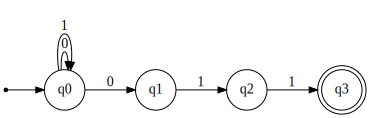

In [220]:
nfav.show_diagram()

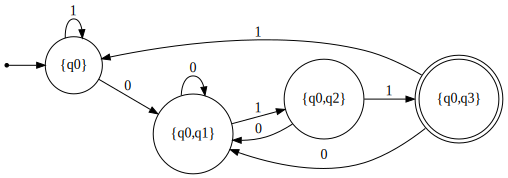

In [221]:
dfav.show_diagram()

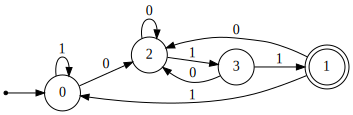

In [222]:
min_dfav.show_diagram()

## Construction à l'aide de l'algorithme de \textsc{Knuth-Morris-Pratt}
L'algorithme KMP consiste à construire récursivement un automate reconnaissant $u$ défini par (on note $P(u)$ l'ensemble des préfixes de $u$): $(A,P(u), \{\epsilon\}, \{u\},\delta)$ où $\forall p\in P(u), \forall x \in \Sigma, \delta(p,x) = s(px)$ en notant $s(v)$ le plus long suffixe de $v$ appartenant à $P(u)$. Cela demande moins de travail, permet de construire explicitement l'automate sans avoir à recourir aux techniques de minimisation, coûteuses en opérations. D'autre part, cela permet aussi de s'affranchir du besoin de la bibliothèque `automata` et de remplir ensuite la table de transition pour appliquer la méthode de \textsc{Karnaugh} directement avec Sympy.

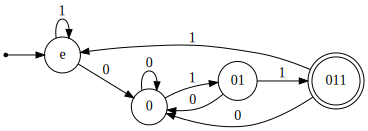

In [223]:
motBinaire = "011"
prefixesMotBinaire = ['e']+[motBinaire[:l] for l in range(1,len(motBinaire)+1)]

alphabet = {"0","1"}
etats = set(prefixesMotBinaire)

delta = {p:{} for p in prefixesMotBinaire}

# on complète les transitions absorbantes pour le premier état
delta['e']['0'] = 'e' if motBinaire[0] != '0' else motBinaire[0]
delta['e']['1'] = 'e' if motBinaire[0] != '1' else motBinaire[0]

# on remplit les transitions à l'aide de l'algorithme KMP
for i in range(0,len(motBinaire)):
    p = motBinaire[0:i+1]
    # print(f'ajout de {p}')
    suffPref0 = [p[j:]+'0' for j in range(len(p)+1) if p[j:]+'0' in prefixesMotBinaire]
    suffPref1 = [p[j:]+'1' for j in range(len(p)+1) if p[j:]+'1' in prefixesMotBinaire]
    delta[p]['0'] = max(suffPref0, key=len) if suffPref0 != [] else 'e'
    # print(f'suffixes pour les transition lisant 0: {suffPref0}')
    # print(f'suffixes pour les transition lisant 1: {suffPref1}')
    delta[p]['1'] = max(suffPref1, key=len) if suffPref1 != [] else 'e'

dfaKMP = DFA(states=etats, input_symbols=alphabet, transitions=delta, initial_state='e', final_states={motBinaire})
dfaKMPv = VisualDFA(dfaKMP)
dfaKMPv.show_diagram(path='./dfaKMP.png')

On obtient exactement le même automate que celui de la section précédente, par déterminisation. Mais nous n'avons pas utilisé l'algorithme de \textsc{Moore}. Remarque: comme tout à l'heure pour obtenir l'automate reconnaissant $\Sigma^*u\Sigma^*$ il suffit de transformer l'état acceptant en puits.

In [224]:
dfaKMP <= min_dfa and dfaKMP <= min_dfa

True

# Création des formules en logique booléennes pour l'implémentation dans LTSpice

In [225]:
## On crée ensuite la table de transition
def integer2binaryArray(i,nBits):
    return np.chararray.astype(np.array(list( format(i, f"0{nBits}b") )),int)

nStates = len(min_dfav.states)
lAlpha  = len(min_dfav.input_symbols)
bStates = np.ceil(np.log2(nStates)).astype(int)
bAlpha = np.ceil(np.log2(lAlpha)).astype(int)
transitionTable = np.zeros((lAlpha*nStates,2*(bStates+2)),dtype=int)

for e in sorted(min_dfav.states):
    en = int(e)
    for c in sorted(min_dfav.input_symbols):
        cn = int(c)
        # numéro état de départ
        transitionTable[en*lAlpha+cn][0]                            = e
        # codage binaire état de départ
        transitionTable[en*lAlpha+cn][1:bStates+1]                  = integer2binaryArray(en,bStates)
        # numéro du caractère lu
        transitionTable[en*lAlpha+cn][bStates+1]                    = cn
        # numéro état d'arrivée
        transitionTable[en*lAlpha+cn][bStates+2]                    = int(min_dfav.transitions[e][c])
        # codage binaire état arrivée
        transitionTable[en*lAlpha+cn][bStates+3:bStates+3+bStates]  = \
        integer2binaryArray(int(min_dfav.transitions[e][c]),bStates)
        # sortie (binaire): état acceptant ou non
        transitionTable[en*lAlpha+cn][bStates+3+bStates]            = \
        int(min_dfav.transitions[e][c] in min_dfav.final_states)

## Réduction par l'algorithme de Quine-McCluskey pour chaque bit de codage de l'état:
## On utilise ici la bibliothèque scientifique sympy


caracteresCodageEtat = ' '.join([f'e{bStates-j-1}' for j in range(bStates)]) # list(string.ascii_lowercase)[:bStates]
symbSortie = sympy.symbols(caracteresCodageEtat)
symbEtats  = sympy.symbols(caracteresCodageEtat+' char')



def solveEtats(q):
    dontcares = [list(np.append(integer2binaryArray(m,bStates),a)) for (m,a) in \
                 itertools.product(range(nStates,2**bStates),range(lAlpha))]
    minterms = [list(r[1:bStates+2]) for r in transitionTable if r[q]]
    return sympy.logic.SOPform(list(symbEtats), minterms, dontcares)

def solveSortie(q):
    dontcares = [list(integer2binaryArray(m,bStates)) for m in range(nStates,2**bStates)]
    minterms = [list(r[1:bStates+1]) for r in transitionTable if r[q]]
    return sympy.logic.SOPform(list(symbSortie), minterms, dontcares)
    
print("Nomenclature: [poids fort] "+caracteresCodageEtat+" [poids faible]\n")
for q in range(bStates+3,bStates+3+bStates):
    print(f"[SOP du bit de poids 2^{2*bStates+2-q}] =  {solveEtats(q)}\n")

print(f"[SOP d'acceptation] =  {solveSortie(2*bStates+3)}")

Nomenclature: [poids fort] e1 e0 [poids faible]

[SOP du bit de poids 2^1] =  ~char | (e1 & ~e0)

[SOP du bit de poids 2^0] =  char & e1

[SOP d'acceptation] =  e0 & e1


Ces formules minimales sont à insérer dans le schéma pour fabriquer une machine de Moore, voir poly de STI
Ci-dessous on affiche la table de transision

In [27]:
def espaceAdaptatif(t,d):
    return str(t) + (d-len(str(t)))*' '

def afficheMatrice(mat):
    print('q  bin(q)'+(2*bStates-4)*' '+'| a | Δ(q,a)'+(2*bStates+4)*' '+'acc?')
    print((2*bStates+29)*'-')
    for i in range(np.shape(mat)[0]):
        t = ''
        t += espaceAdaptatif(mat[i][0],3)  \
          + str(mat[i][1:bStates+1]) + ' | ' + str(mat[i][bStates+1]) + ' | ' + espaceAdaptatif(mat[i][bStates+2],2) +4*' ' + str(mat[i][bStates+3:2*bStates+3]) + ' | ' + str(mat[i][-1]) 
        print(t)
afficheMatrice(transitionTable)

q  bin(q)  | a | Δ(q,a)          acc?
-----------------------------------
0  [0 0 0] | 0 | 0     [0 0 0] | 0
0  [0 0 0] | 1 | 3     [0 1 1] | 0
1  [0 0 1] | 0 | 0     [0 0 0] | 0
1  [0 0 1] | 1 | 5     [1 0 1] | 0
2  [0 1 0] | 0 | 1     [0 0 1] | 1
2  [0 1 0] | 1 | 3     [0 1 1] | 0
3  [0 1 1] | 0 | 4     [1 0 0] | 0
3  [0 1 1] | 1 | 3     [0 1 1] | 0
4  [1 0 0] | 0 | 0     [0 0 0] | 0
4  [1 0 0] | 1 | 5     [1 0 1] | 0
5  [1 0 1] | 0 | 4     [1 0 0] | 0
5  [1 0 1] | 1 | 2     [0 1 0] | 0


On peut ainsi créer le schéma à partir des formules fournies par le code dans LTSpice :
<img src="schema.png" width="800"/>
\begin{figure}[htbp]
\centering
\includegraphics[width=0.8\textwidth,trim={0cm 0cm 0cm 0cm},clip]{schema.png}
\caption{Schéma électrique}
\label{fig:schema}
\end{figure}
et constater que le résultat donné est bien celui attendu (figure \ref{fig:schema} et \ref{fig:chronogramme}). Le circuit valide une entrée se terminant par '011' sur les fronts montants.
<img src="tensions.png"/>
\begin{figure}[htbp]
\centering
\includegraphics[width=0.8\textwidth,trim={0cm 0cm 0cm 0cm},clip]{tensions.png}
\caption{Chronogramme du schéma électrique}
\label{fig:chronogramme}
\end{figure}

#### Brouillon

In [28]:
list(symbols('u v c'))

[u, v, c]

In [29]:
alphabet_string = string.ascii_lowercase
alphabet_list = list(alphabet_string)

In [30]:
symb = ' '.join(alphabet_list)
symb

'a b c d e f g h i j k l m n o p q r s t u v w x y z'

In [31]:
list(symbols(symb))


[a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z]

In [32]:
' '.join(alphabet_list[:bStates])+' etat'

'a b c etat'